In [1]:
import pandas as pd
import sys
import numpy as np
from scipy.misc import imshow, imresize
import imageio
import os
import random

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

Using TensorFlow backend.


In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from wordcloud import WordCloud, STOPWORDS 

def makeWordmap(strList, saveFileName):
    words = ' '.join(strList)
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.savefig(saveFileName)
    plt.show() 

In [4]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [5]:

# Images are 500x500 numpy arrays 
def load_model():
    np.random.seed(1234)

    model = Sequential()
    model.add(Dense(512, input_shape=(300,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination, 'mae'])
#     print(model.summary())
    return model


In [10]:
data = np.load("/atlas/u/esheehan/wikipedia_project/dataset/GUF_dataset/data/AfricaArticleClustersUpdated.npy")

In [11]:

def load_data(num=10, testIdx = 0):

#     data = np.load("/atlas/u/esheehan/wikipedia_project/dataset/GUF_dataset/data/AfricaArticleClustersUpdated.npy")
    #data = np.load("/atlas/u/esheehan/wikipedia_project/dataset/GUF_dataset/data/AfricaDataWithCountry.npy")
    #data = np.load("/atlas/u/esheehan/wikipedia_project/dataset/GUF_dataset/data/AfricaArticleClusters.npy")
#     print(len(data))
#     print("Number of closest articles: ", num)

    X,Y = [], []
    for i in data:
        if i[1] == "UGA":
        #if len(i) == 7:
            if not num == 10:
                embeddings = [j[4] for j in i[6][:num]]
                av = []
                for k in range(len(embeddings[0])):
                    sum_ = 0
                    for j in embeddings:
                        sum_ += j[k]
                    sum_ /= float(len(embeddings))
                    av.append(sum_)
                X.append(av)
            else:
                X.append(i[5]) # Real X 

                # Generate Fake Vector 
#                 r = []
#                 for _ in range(300):
# #                     r.append(random.uniform(-2, 3))
#                     r.append(0)
#                 r[testIdx] = i[5][testIdx]
#                 X.append(r)

#             r = np.random.normal()
#             while r > 0: 
#                 r = np.random.normal()
#             Y.append(r)

            Y.append(i[2]) # Real Y 

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=1234, shuffle=True)
    X_train, X_test, Y_train, Y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(Y_train), np.asarray(Y_test)
    
    # Shuffle X
    random.shuffle(X_train)
    random.shuffle(X_test)

#     print("X_train Shape: ", X_train.shape)
#     print("X_test Shape: ", X_test.shape)
#     print("Y_train Shape: ", Y_train.shape)
#     print("Y_test Shape: ", Y_test.shape)

#     print("Data Loaded") 
    return X_train, X_test, Y_train, Y_test


In [12]:
def run_model(weightsName, num=10, testIdx = 0):

    X_train, X_test, Y_train, Y_test = load_data(num, testIdx) 
    reg = load_model()
    reg= KerasRegressor(build_fn=load_model, epochs=10, verbose=0,validation_split=0.0)

    print("Testing model")
    reg.fit(X_train, Y_train)
    prediction=reg.predict(X_test)
    print("R2: ", r2_score(Y_test, prediction))
    print("Pearson's r: ", pearsonr(Y_test, prediction)[0]**2)
    
#     np.save("/atlas/u/esheehan/wikipedia_project/dataset/GUF_dataset/output/pred", prediction)
#     np.save("/atlas/u/esheehan/wikipedia_project/dataset/GUF_dataset/output/test", Y_test)

    result = np.sqrt(mean_squared_error(Y_test, prediction))
    print("Testing RMSE: {}".format(result))
    
#     print("Saving model to: ", weightsName) 
#     reg.model.save(weightsName)

    return r2_score(Y_test, prediction), pearsonr(Y_test, prediction)[0]**2

In [13]:
rootDir = "/atlas/u/esheehan/wikipedia_project/dataset/GUF_dataset/"

outputPath = rootDir + "output/baselineDoc2VecModelOut/"
weightsPath = rootDir + "output/baselineDoc2VecModelOut/weights/"
logPath = rootDir + "output/baselineDoc2VecModelOut/logs/"

filename = "randomRun"

if not os.path.exists(outputPath): 
    print("{} does not exist, creating it now".format(outputPath))
    os.makedirs(outputPath)
    os.makedirs(weightsPath)
    os.makedirs(logPath)

# Set up logging 
#     sys.stdout = open(logPath + filename + ".txt", 'w')
print("Running model") 

r2List = []
pearsonRList = []
for i in range(100):
    print("Starting evaluation of ", i)
    curR2, curPear = run_model(weightsPath + filename + ".hdf5", 10, testIdx = i)
    r2List.append(curR2)
    pearsonRList.append(curPear)



Running model
Starting evaluation of  0
Testing model
R2:  -0.025007220236134886
Pearson's r:  0.00023960190280869934
Testing RMSE: 0.4945394135410729
Starting evaluation of  1
Testing model
R2:  -0.02395558934781672
Pearson's r:  0.01624153025636189
Testing RMSE: 0.49428565611560543
Starting evaluation of  2
Testing model
R2:  -0.02315884215367814
Pearson's r:  0.013269830378949776
Testing RMSE: 0.49409331508430954
Starting evaluation of  3
Testing model
R2:  -0.02486566804001278
Pearson's r:  0.0015088485170869155
Testing RMSE: 0.4945052647293978
Starting evaluation of  4
Testing model
R2:  -0.06059087955398512
Pearson's r:  7.827507492672557e-05
Testing RMSE: 0.5030502755719239
Starting evaluation of  5
Testing model
R2:  -0.03227639918158487
Pearson's r:  0.0001018786962386593
Testing RMSE: 0.4962899106710722
Starting evaluation of  6
Testing model
R2:  -0.022521338259104517
Pearson's r:  0.007457250136521962
Testing RMSE: 0.49393936269688965
Starting evaluation of  7
Testing model

R2:  -0.08223294013894966
Pearson's r:  0.0004448232699441158
Testing RMSE: 0.5081568934683929
Starting evaluation of  62
Testing model
R2:  -0.07942431633661307
Pearson's r:  0.0003665679195996504
Testing RMSE: 0.5074970776919323
Starting evaluation of  63
Testing model
R2:  -0.08547097844074591
Pearson's r:  0.0035829701343600227
Testing RMSE: 0.5089165277760643
Starting evaluation of  64
Testing model
R2:  -0.08097406665915319
Pearson's r:  0.00021610173322330126
Testing RMSE: 0.507861258697651
Starting evaluation of  65
Testing model
R2:  -0.07431959409617384
Pearson's r:  0.002644822382148307
Testing RMSE: 0.5062956494431058
Starting evaluation of  66
Testing model
R2:  -0.1023842748191448
Pearson's r:  0.017120644628598632
Testing RMSE: 0.512866050890818
Starting evaluation of  67
Testing model
R2:  -0.019311727122565348
Pearson's r:  0.024329934327148344
Testing RMSE: 0.4931635357043542
Starting evaluation of  68
Testing model
R2:  -0.07398885900153096
Pearson's r:  0.0063735447

In [14]:
# np.save("Doc2VecNoiseImportance.npy", r2List)

In [15]:
# r2List = np.load(Doc2VecNoiseImportance.npy)

Plotting: 


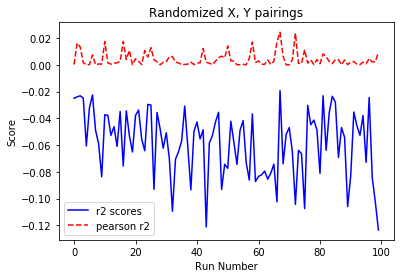

In [18]:
print("Plotting: ")
x = range(100)
fig, ax = plt.subplots()
ax.plot(x, r2List, '-b', label='r2 scores')
ax.plot(x, pearsonRList, '--r', label='pearson r2')

plt.xlabel("Run Number")
plt.ylabel("Score")
plt.title("Randomized X, Y pairings")

leg = ax.legend();

# plt.savefig("randomXY.png")


In [10]:
# Analyze high value threshold
THRESH = 0.25

r2List = np.asarray(r2List)
mask = r2List > THRESH

bestPredictors = [] 
for i in range(len(mask)):
    if mask[i] == True:
        bestPredictors.append(i)

print(bestPredictors)


[24, 182]


Plotting average idx = 24
Plotting average idx = 182


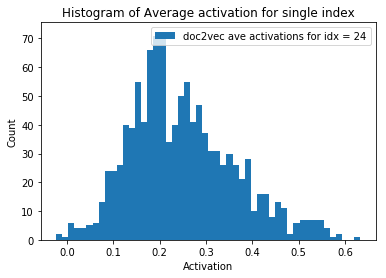

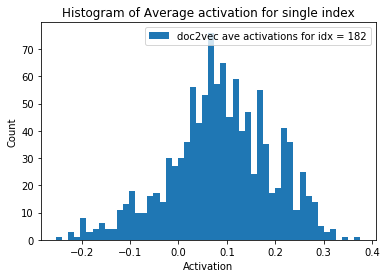

In [37]:
def plotAveIdxVals(idx, data):
    toPlot = []
    print("Plotting average idx = {}".format(idx))
    for i in data: 
        if i[1] == "UGA":
            toPlot.append(i[5][idx])
    x = range(len(toPlot))
    fig, ax = plt.subplots()
    #     ax.plot(x, toPlot, '-b', label='doc2vec activations for idx = {}'.format(idx))
    ax.hist(toPlot, bins=50, label='doc2vec ave activations for idx = {}'.format(idx))
    
    
    plt.xlabel("Activation")
    plt.ylabel("Count")
    plt.title("Histogram of Average activation for single index")

    leg = ax.legend();

#     plt.savefig("aveSingle{}.png".format(idx))

    
for idx in bestPredictors:
    plotAveIdxVals(idx, data)
    

Plotting average idx = 24


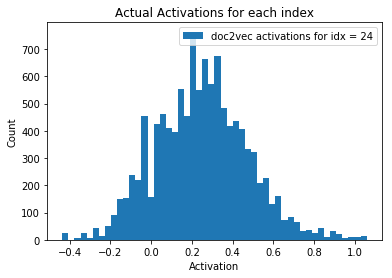

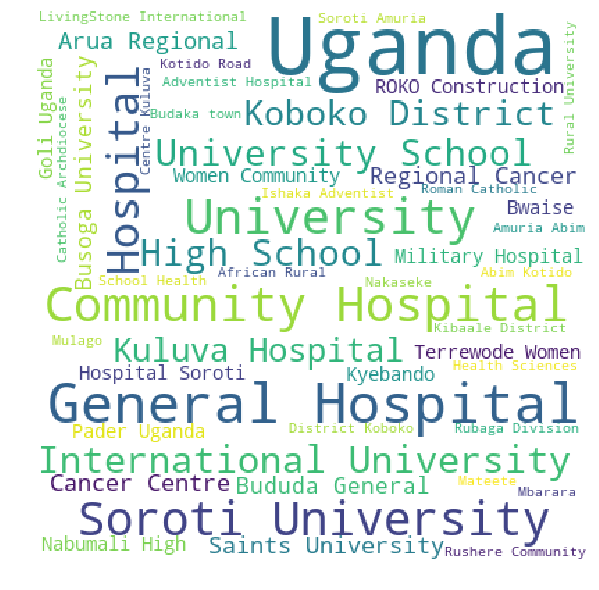

Plotting average idx = 182


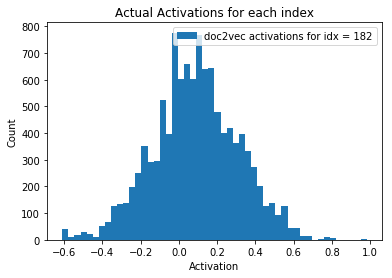

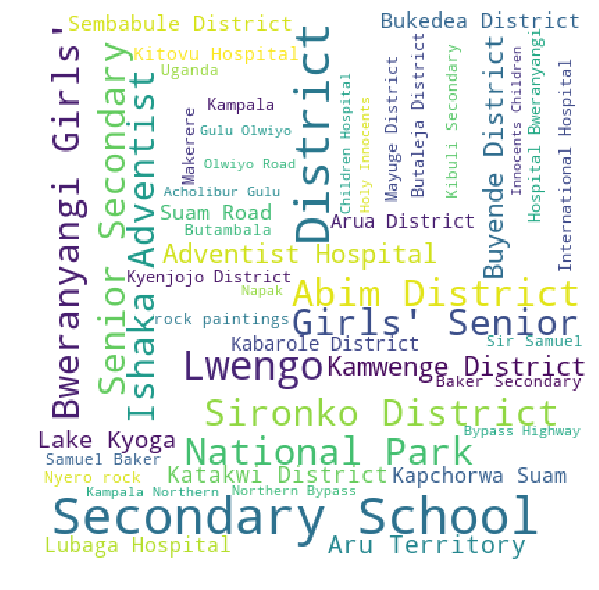

In [50]:
def plotIdxVals(idx, data):
    toPlot = []
    names = []
    print("Plotting average idx = {}".format(idx))
    for i in data: 
        if i[1] == "UGA":
            for j in i[6]:
                toPlot.append(j[4][idx])
                if abs(j[4][idx]) > 0.5:
                    names.append(j[1])
    x = range(len(toPlot))
    fig, ax = plt.subplots()
    ax.hist(toPlot, bins=50, label='doc2vec activations for idx = {}'.format(idx))
    
    plt.xlabel("Activation")
    plt.ylabel("Count")
    plt.title("Actual Activations for each index")
    
    leg = ax.legend();
    
#     plt.savefig("singleActivationAll{}.png".format(idx))
    return names 

for idx in bestPredictors:
    names = plotIdxVals(idx, data)
#     names = set(names)
#     names = list(names)
#     names.sort()
#     print(names[0:30])
    makeWordmap(names, "wordMapTitles{}.png".format(idx))
    

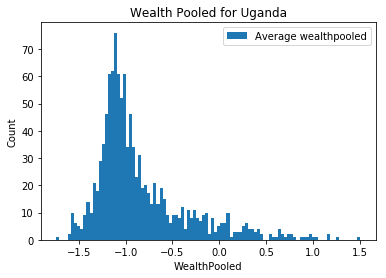

In [41]:
def plotIdxVals(data):
    toPlot = []
    for i in data: 
        if i[1] == "UGA":
            toPlot.append(i[2])
    x = range(len(toPlot))
    fig, ax = plt.subplots()
    ax.hist(toPlot, bins=100, label='Average wealthpooled')
    
    plt.xlabel("WealthPooled")
    plt.ylabel("Count")
    plt.title("Wealth Pooled for Uganda")
    
    leg = ax.legend();
    
#     plt.savefig("WealthpoolUganda.png")
    
plotIdxVals(data)

Plotting average idx = 24
Nonecount: 10


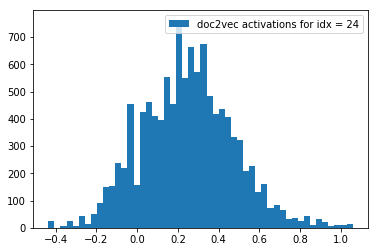

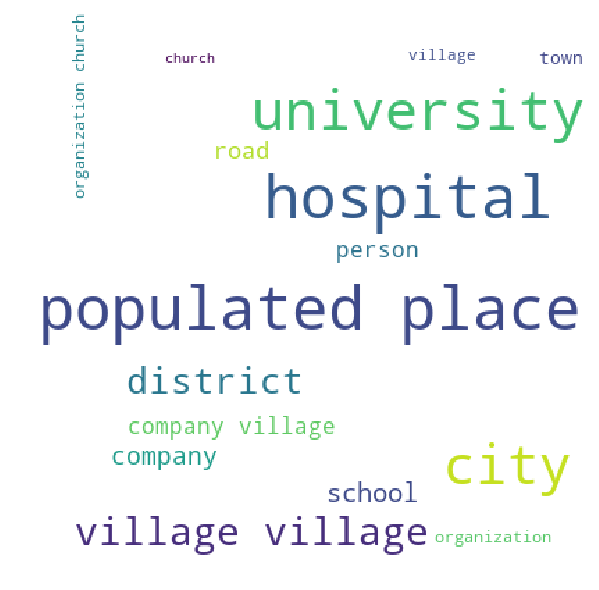

Plotting average idx = 182
Nonecount: 8


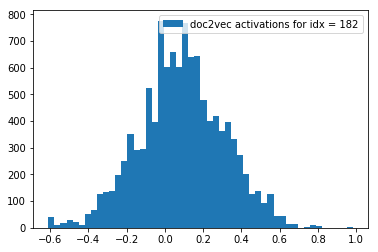

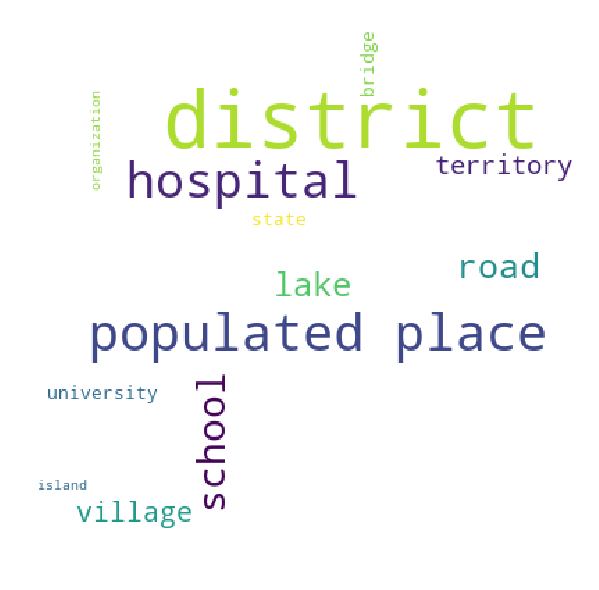

In [51]:
def plotIdxVals(idx, data):
    toPlot = []
    names = []
    print("Plotting average idx = {}".format(idx))
    noneCount = 0
    for i in data: 
        if i[1] == "UGA":
            for j in i[6]:
                toPlot.append(j[4][idx])
                if abs(j[4][idx]) > 0.5:
                    if j[3] is not None:
                        names.append(j[3])
                    else: 
                        noneCount += 1
    x = range(len(toPlot))
    fig, ax = plt.subplots()
#     ax.plot(x, toPlot, '-b', label='doc2vec activations for idx = {}'.format(idx))
    ax.hist(toPlot, bins=50, label='doc2vec activations for idx = {}'.format(idx))
    leg = ax.legend();
    
    print("Nonecount: {}".format(noneCount))
    return names 

for idx in bestPredictors:
    names = plotIdxVals(idx, data)
#     names = set(names)
#     names = list(names)
#     names.sort()
#     print(names[0:30])
    makeWordmap(names, "wordMapCategories{}.png".format(idx))
    